First 5 rows of the dataset:
   Performance Index  Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  Sample Question Papers Practiced
0                 91              7               99                           1            9                                 1
1                 65              4               82                           0            4                                 2
2                 45              8               51                           1            7                                 2
3                 36              5               52                           1            5                                 2
4                 66              7               75                           0            8                                 5

Number of rows: 10000, Number of columns: 6



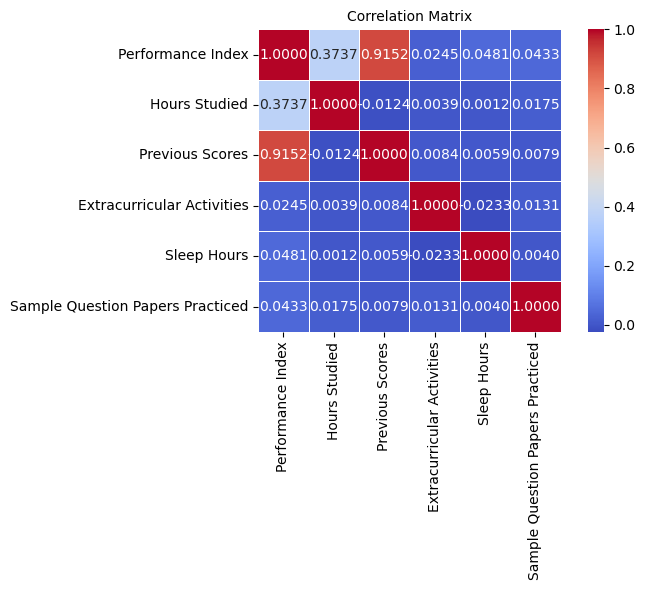


Model Summary
------------------------------------------------------------------------------------
Model  R       R Square   Adjusted R Square  Std. Error of the Estimate
1      0.994   0.989      0.989              2.038                    

a. Predictors: (Constant, Hours Studied, Previous Scores, Extracurricular Activities, Sleep Hours, Sample Question Papers Practiced)

Assumption Checks
------------------------------------------------------------------------------------
Durbin-Watson (Independence of Residuals): 2.001
   - Values around 2 indicate no autocorrelation.
Harvey-Collier Test (Linearity): T-value=nan, P-value=nan
   No evidence of non-linearity at 5% significance.
Breusch-Pagan Test (Homoscedasticity): Chi-Sq=2.159, P-value=0.827
   No evidence of heteroscedasticity.
Levene's Test (Homoscedasticity): Stat=1.691, P-value=0.194
   No evidence of heteroscedasticity between groups.

First 5 Studentized Residuals: [-0.41823702  0.90414777 -0.0259294  -0.27051124 -0.53556136

C:\Users\OUM\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


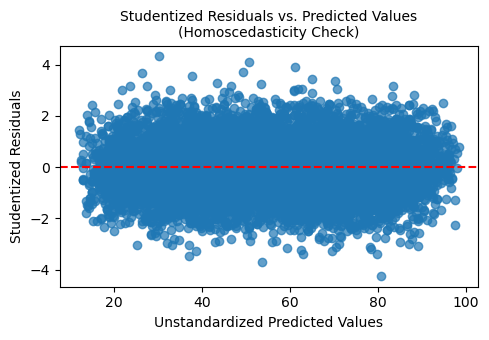

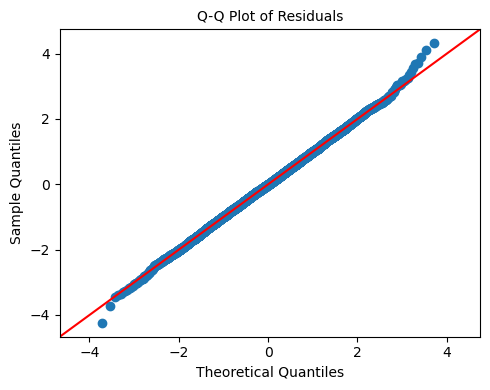

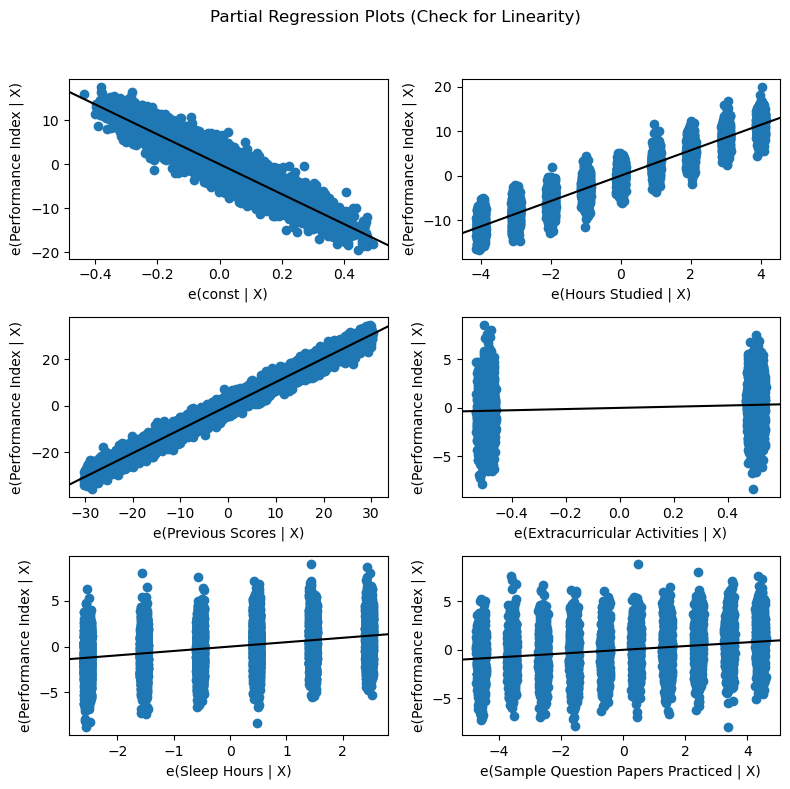


Partial R² for Each Predictor
+----------------------------------+------------+
| Predictor Variable               | Partial R² |
+----------------------------------+------------+
| Hours Studied                    | 0.929      |
| Previous Scores                  | 0.987      |
| Extracurricular Activities       | 0.022      |
| Sleep Hours                      | 0.138      |
| Sample Question Papers Practiced | 0.069      |
+----------------------------------+------------+


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f, kstest, shapiro  # Added kstest and shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import linear_harvey_collier, het_breuschpagan
from scipy.stats import levene
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================#
#         User Settings         #
# ==============================#

# Specify the path to your CSV dataset here
FILE_PATH = "data_1 regression.csv"  # Replace with your actual file path

# Option to plot graphs
PLOT_GRAPHS = True

# ==============================#
#        Function Definition    #
# ==============================#

def analyze_csv_data(file_path, plot_graphs=False):
    # Adjust Pandas display settings to show all columns side by side
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 1000)        # Increase the display width if necessary
    pd.set_option('display.max_colwidth', None) # Show full column content
    pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

    # Load the data from CSV at the top
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
        return
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
        return

    # Display first 5 rows and dataset dimensions
    print("First 5 rows of the dataset:")
    print(df.head())
    print(f"\nNumber of rows: {df.shape[0]}, Number of columns: {df.shape[1]}\n")

    # Reset Pandas display options to default
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')
    pd.reset_option('display.expand_frame_repr')

    # Identify dependent and independent variables
    y_column = df.columns[0]
    x_columns = df.columns[1:]

    # Display correlation matrix as a heatmap
    corr = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".4f",
                square=True, linewidths=.5, cbar=True)
    plt.title('Correlation Matrix', fontsize=10)
    plt.tight_layout()
    plt.show()
    print()  # Blank line after the plot

    # Extract data for regression
    y = df[y_column]
    X = df[x_columns]
    X_const = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X_const).fit()

    # Basic stats
    n = len(y)
    p = len(x_columns)
    y_pred = model.fittedvalues
    y_mean = y.mean()

    r_squared = model.rsquared
    adjusted_r_squared = model.rsquared_adj
    SSE = np.sum((y - y_pred)**2)
    SST = np.sum((y - y_mean)**2)
    SSR = SST - SSE
    MSE = SSE / (n - p - 1)
    MSR = SSR / p
    F_stat = MSR / MSE
    p_value = 1 - f.cdf(F_stat, p, n - p - 1)
    std_error_estimate = np.sqrt(MSE)
    R = np.sqrt(r_squared)

    # Standardized coefficients
    X_std = (X - X.mean()) / X.std(ddof=1)
    y_std = (y - y.mean()) / y.std(ddof=1)
    X_std_const = sm.add_constant(X_std)
    model_std = sm.OLS(y_std, X_std_const).fit()
    beta = model_std.params

    params = model.params
    std_err = model.bse
    t_vals = model.tvalues
    p_vals = model.pvalues
    conf_int = model.conf_int(alpha=0.05)

    # Assumption checks
    dw_stat = durbin_watson(model.resid)
    hc_test = linear_harvey_collier(model)
    hc_tvalue, hc_pvalue = hc_test
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    bp_stat, bp_pvalue, bp_fstat, bp_f_pvalue = bp_test

    median_pred = np.median(y_pred)
    group1 = model.resid[y_pred <= median_pred]
    group2 = model.resid[y_pred > median_pred]
    lev_stat, lev_pvalue = levene(group1, group2)

    influence = model.get_influence()
    stud_resid = influence.resid_studentized_internal
    unstd_pred = y_pred

    print("Model Summary")
    print("------------------------------------------------------------------------------------")
    print("{:<6} {:<7} {:<10} {:<18} {:<25}".format("Model", "R", "R Square", "Adjusted R Square", "Std. Error of the Estimate"))
    print("{:<6} {:<7.3f} {:<10.3f} {:<18.3f} {:<25.3f}".format("1", R, r_squared, adjusted_r_squared, std_error_estimate))
    print()
    print(f"a. Predictors: (Constant, {', '.join(x_columns)})")
    print()

    print("Assumption Checks")
    print("------------------------------------------------------------------------------------")
    print(f"Durbin-Watson (Independence of Residuals): {dw_stat:.3f}")
    print("   - Values around 2 indicate no autocorrelation.")
    print(f"Harvey-Collier Test (Linearity): T-value={hc_tvalue:.3f}, P-value={hc_pvalue:.3f}")
    if hc_pvalue < 0.05:
        print("   Suggests a non-linear relationship at 5% significance.")
    else:
        print("   No evidence of non-linearity at 5% significance.")

    print(f"Breusch-Pagan Test (Homoscedasticity): Chi-Sq={bp_stat:.3f}, P-value={bp_pvalue:.3f}")
    if bp_pvalue < 0.05:
        print("   Indicates heteroscedasticity (variance not constant).")
    else:
        print("   No evidence of heteroscedasticity.")

    print(f"Levene's Test (Homoscedasticity): Stat={lev_stat:.3f}, P-value={lev_pvalue:.3f}")
    if lev_pvalue < 0.05:
        print("   Variances differ significantly between median-based groups.")
    else:
        print("   No evidence of heteroscedasticity between groups.")

    print("\nFirst 5 Studentized Residuals:", stud_resid[:5])
    print("First 5 Unstandardized Predicted Values:", unstd_pred[:5])
    print()

    # Additional Normality Tests
    print("Additional Normality Tests")
    print("------------------------------------------------------------------------------------")

    # Extract residuals from the model
    residuals = model.resid

    # Kolmogorov-Smirnov Test for Normality
    # Comparing residuals to a normal distribution with the same mean and standard deviation
    residuals_mean = residuals.mean()
    residuals_std = residuals.std(ddof=1)
    ks_stat, ks_pvalue = kstest(residuals, 'norm', args=(residuals_mean, residuals_std))
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_stat:.3f}, P-value={ks_pvalue:.3f}")
    if ks_pvalue < 0.05:
        print("   The residuals do NOT follow a normal distribution (reject H0).")
    else:
        print("   The residuals follow a normal distribution (fail to reject H0).")

    # Shapiro-Wilk Test for Normality
    shapiro_stat, shapiro_pvalue = shapiro(residuals)
    print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.3f}, P-value={shapiro_pvalue:.3f}")
    if shapiro_pvalue < 0.05:
        print("   The residuals do NOT follow a normal distribution (reject H0).")
    else:
        print("   The residuals follow a normal distribution (fail to reject H0).")
    print()

    # ANOVA table
    anova_headers = ["Model", "Sum of Squares", "df", "Mean Square", "F", "Sig."]
    anova_data = [
        ["Regression", f"{SSR:.3f}", str(p), f"{MSR:.3f}", f"{F_stat:.3f}", f"{p_value:.3f}"],
        ["Residual", f"{SSE:.3f}", str(n - p - 1), f"{MSE:.3f}", "", ""],
        ["Total", f"{SST:.3f}", str(n - 1), "", "", ""]
    ]
    anova_col_widths = [max(len(h), *(len(row[i]) for row in anova_data)) for i, h in enumerate(anova_headers)]

    def print_table_with_borders(headers, data, col_widths):
        print("+" + "+".join(["-"*(w+2) for w in col_widths]) + "+")
        print("|" + "|".join([" " + h.ljust(w) + " " for h, w in zip(headers, col_widths)]) + "|")
        print("+" + "+".join(["-"*(w+2) for w in col_widths]) + "+")
        for row in data:
            print("|" + "|".join([" " + cell.ljust(w) + " " for cell, w in zip(row, col_widths)]) + "|")
        print("+" + "+".join(["-"*(w+2) for w in col_widths]) + "+")

    print("ANOVA")
    print("------------------------------------------------------------------------------------")
    print_table_with_borders(anova_headers, anova_data, anova_col_widths)
    print()
    print(f"a. Dependent Variable: {y_column}")
    print(f"b. Predictors: (Constant, {', '.join(x_columns)})")
    print()

    # Coefficients table
    coeff_headers = ["Model", "Variable Name", "Unstd. B", "Std. Error", "Beta", "t", "Sig.", "Lower 95%", "Upper 95%"]
    coeff_data = [
        ["1", "(Constant)", f"{params['const']:.3f}", f"{std_err['const']:.3f}",
         f"{beta['const']:.3f}", f"{t_vals['const']:.3f}", f"{p_vals['const']:.3g}",
         f"{conf_int.loc['const',0]:.3f}", f"{conf_int.loc['const',1]:.3f}"]
    ]
    for var in x_columns:
        coeff_data.append(["", var,
                           f"{params[var]:.3f}", f"{std_err[var]:.3f}", f"{beta[var]:.3f}",
                           f"{t_vals[var]:.3f}", f"{p_vals[var]:.3g}",
                           f"{conf_int.loc[var,0]:.3f}", f"{conf_int.loc[var,1]:.3f}"])
    coeff_col_widths = [max(len(h), *(len(row[i]) for row in coeff_data)) for i, h in enumerate(coeff_headers)]

    print("Coefficients")
    print("------------------------------------------------------------------------------------")
    print_table_with_borders(coeff_headers, coeff_data, coeff_col_widths)
    print()
    print(f"a. Dependent Variable: {y_column}")

    # Print the regression equation
    intercept = params['const']
    equation_terms = [f"{params[var]:.3f}*{var}" for var in x_columns]
    equation_str = f"{y_column} = {intercept:.3f} + " + " + ".join(equation_terms)
    print("\nRegression Equation:")
    print(equation_str)

    # If plot_graphs is True, create diagnostic plots
    partial_r2_list = []
    if plot_graphs:
        # Plot Studentized Residuals vs. Fitted Values with reduced size
        plt.figure(figsize=(5, 3.5))  # Reduced size
        plt.scatter(y_pred, stud_resid, alpha=0.7)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Unstandardized Predicted Values")
        plt.ylabel("Studentized Residuals")
        plt.title("Studentized Residuals vs. Predicted Values\n(Homoscedasticity Check)", fontsize=10)
        plt.tight_layout()
        plt.show()

        # Q-Q Plot of Residuals with reduced size
        plt.figure(figsize=(5, 4))  # Reduced size
        sm.qqplot(model.resid, line='45', fit=True, ax=plt.gca())
        plt.title("Q-Q Plot of Residuals", fontsize=10)
        plt.tight_layout()
        plt.show()

        # Partial Regression Plots with reduced spacing and size
        fig = plt.figure(figsize=(8, 8))  # Reduced size
        sm.graphics.plot_partregress_grid(model, fig=fig)
        plt.suptitle("Partial Regression Plots (Check for Linearity)", fontsize=12, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to reduce spacing
        plt.show()

        # Compute partial R² for each predictor
        for var in x_columns:
            others = [v for v in x_columns if v != var]
            X_others = sm.add_constant(df[others])
            mod_y = sm.OLS(y, X_others).fit()
            resY = mod_y.resid

            mod_x = sm.OLS(df[var], X_others).fit()
            resX = mod_x.resid

            r = np.corrcoef(resY, resX)[0,1]
            partial_r2 = r**2

            partial_r2_list.append((var, partial_r2))

        # Print Partial R² table
        var_name_length = max(len(v) for v, _ in partial_r2_list)
        col1_width = max(var_name_length, len("Predictor Variable"))
        col2_width = len("Partial R²")

        print("\nPartial R² for Each Predictor")
        print("+" + "-"*(col1_width+2) + "+" + "-"*(col2_width+2) + "+")
        print("| " + "Predictor Variable".ljust(col1_width) + " | " + "Partial R²".ljust(col2_width) + " |")
        print("+" + "-"*(col1_width+2) + "+" + "-"*(col2_width+2) + "+")
        for var, r2_val in partial_r2_list:
            print("| " + var.ljust(col1_width) + " | " + f"{r2_val:.3f}".ljust(col2_width) + " |")
        print("+" + "-"*(col1_width+2) + "+" + "-"*(col2_width+2) + "+")

# ==============================#
#         Main Execution        #
# ==============================#

if __name__ == "__main__":
    analyze_csv_data(FILE_PATH, plot_graphs=PLOT_GRAPHS)
